## Introduction

The purpose of this notebook is to explore possible relationships between socioeconomic factors and average ACT scores to determine whether or not academic excellence is affected by socioeconomic conditions. If so, this notebook will also aim to determine the magnitude in which these factors affect standardized test scores.

## Import libraries

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
sns.set_theme(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Load clean data

All socioeconomic data (household income, unemployment, adult educational attainment, and family structure) are from the Census Bureau's American Community Survey.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) report that ACT and SAT score data is from each state's department of education or some other public data release. The nature of the other public data release is not known.

The quality of the census data and the department of education data can be assumed to be reasonably high.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) do not indicate that they processed the data in any way. The data were assembled by the [EdGap.org](https://www.edgap.org/#5/37.875/-96.987) team, so there is always the possibility for human error. Given the public nature of the data, we would be able to consult the original data sources to check the quality of the data if we had any questions.

The school information data is from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp). This data set consists of basic identifying information about schools and can be assumed to be of reasonably high quality. As for the EdGap.org data, the school information data is public, so we would be able to consult the original data sources to check the quality of the data if we had any questions.


##### $\rightarrow$ Load the clean data set from Github.

In [141]:
# This is the clean training dataset achieved from the 'data preparation' notebook I made previously.
train_set = pd.read_csv('https://github.com/nrg-frogusa/Education-Inequality/raw/main/training_set_education.csv')

In [142]:
# And this is the clean testing dataset from that same notebook.
test_set = pd.read_csv('https://github.com/nrg-frogusa/Education-Inequality/raw/main/testing_set_education.csv')

##### $\rightarrow$ Review the contents of the data set.

In [143]:
train_set.head()

,id,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,year,state,zip_code,school_type,school_level,average_act
0,551341001759,-0.531528,0.213390,0.403520,-0.057001,-0.819509,2016-2017,WI,53578,Regular School,High,23.700000
1,120051000805,-0.208309,1.605636,0.464010,-0.155804,0.560818,2016-2017,FL,32501,Regular School,High,25.744811
2,370309001328,-0.231998,0.104839,-0.361537,-0.387345,-0.560154,2016-2017,NC,28326,Regular School,High,22.838828
3,482574005522,-0.274693,0.307986,0.428813,0.246545,0.787274,2016-2017,TX,77066,Regular School,High,18.736264
4,120165001826,2.179852,-0.551851,0.259147,-0.822336,0.074887,2016-2017,FL,32570,Regular School,High,18.492063


In [144]:
test_set.head()

,id,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,year,state,zip_code,school_type,school_level,average_act
0,483930007019,0.784408,0.303376,-0.584931,-1.145041,-0.552292,2016-2017,TX,78363,Regular School,High,20.714286
1,130051002455,0.318269,-0.424495,-0.491165,-0.304655,-0.968441,2016-2017,GA,30110,Regular School,High,21.178266
2,481623001387,-0.772969,2.213585,0.093265,-0.047401,0.645293,2016-2017,TX,75214,Regular School,High,19.273504
3,370001202616,-0.572138,1.472247,0.574501,0.070561,0.009750,2016-2017,NC,28590,Regular School,High,19.493284
4,250993001596,1.717103,0.551565,1.206253,0.208768,0.161540,2016-2017,MA,2368,Regular School,High,19.200244


In [145]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6300 non-null   int64  
 1   rate_unemployment  6300 non-null   float64
 2   percent_college    6300 non-null   float64
 3   percent_married    6300 non-null   float64
 4   median_income      6300 non-null   float64
 5   percent_lunch      6300 non-null   float64
 6   year               6300 non-null   object 
 7   state              6300 non-null   object 
 8   zip_code           6300 non-null   int64  
 9   school_type        6300 non-null   object 
 10  school_level       6300 non-null   object 
 11  average_act        6300 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 590.8+ KB


In [146]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1575 non-null   int64  
 1   rate_unemployment  1575 non-null   float64
 2   percent_college    1575 non-null   float64
 3   percent_married    1575 non-null   float64
 4   median_income      1575 non-null   float64
 5   percent_lunch      1575 non-null   float64
 6   year               1575 non-null   object 
 7   state              1575 non-null   object 
 8   zip_code           1575 non-null   int64  
 9   school_type        1575 non-null   object 
 10  school_level       1575 non-null   object 
 11  average_act        1575 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 147.8+ KB


Just verifying the datasets are consistent with the ones we exported from the data preparation process. It seems they all are.

## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.

- How does the variation in median household income within the same state affect the average ACT scores?
  - In this way, we can figure out how income and wealth levels affects ACT scores. It would be valuable to separate it by state because income levels will correlate to different levels of "affluence" from state-to-state.
  - Households that earn 'x' amount of money in New York will be less affluent there than another household earning the same 'x' amount in a place like West Virginia.
- What is the relationship between each socioeconomic factor (unemployment rate, marriage rate, college attendance rate, etc.) and average ACT scores?
  - Here we want to learn how average ACT score relates/correlates to the other quantitative variables.
- Is a regression that takes the above socioeconomic factors into account able accurately predict average ACT scores? If not, how could it be improved?
  - We want to test a regression model to see how well we could predict average ACT scores based on the socioeconomic variables that we have in the dataset (unemployment rate, marriage rate, median income, etc.).

## Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

This file should clearly produce the graphs, tables, models, etc that appear in the communication assignment.

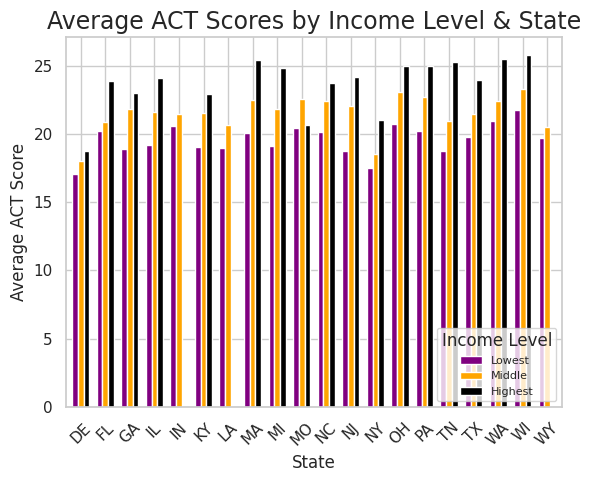

<Figure size 1800x1500 with 0 Axes>

In [147]:
# Group the median income and states together in 3 separate bins to get them to plot cohesively.
group_by_state_and_income = train_set.groupby(['state', pd.cut(train_set['median_income'], bins=3, labels=['Lowest', 'Middle', 'Highest'])])
average_act_by_group = group_by_state_and_income['average_act'].mean()

# Make a bar chart to display the 3 variables we declared above.
average_act_by_group.unstack().plot(kind='bar', color=['purple', 'orange', 'black'], width=0.7)
plt.ylabel('Average ACT Score')
plt.xlabel('State')
plt.title('Average ACT Scores by Income Level & State', fontsize=17)
plt.xticks(rotation=45)
plt.legend(title='Income Level', labels=['Lowest', 'Middle', 'Highest'], loc='lower right',prop={'size':8})
plt.figure(figsize=(18, 15))

plt.show()

# Analysis
Since the black bar represents the highest income level and they're consistently higher than the other 2 levels, we can conclude that higher levels of income correlate to higher average ACT scores across all states.

In [148]:
# Plotting function for the test-train split we'll perform.
def plot_results(y_train, y_test, y_pred_train, y_pred_test):
  one_train = np.linspace(y_train.min(), y_train.max(), 100)
  one_test = np.linspace(y_test.min(), y_test.max(), 100)
  rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
  rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))

  # Create the training plot.
  fig,(ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(y_pred_train, y_train, 'o')
  ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
  ax1.set_title("Training Set")
  ax1.set_xlabel("Predicted ACT Score")
  ax1.set_ylabel("Actual ACT Score")
  ax1.legend()
  # Create the testing plot.
  ax2.plot(y_pred_test, y_test, 'o')
  ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} points")
  ax2.legend()
  ax2.set_title("Test Set")
  ax2.set_xlabel("Predicted ACT Score")
  ax2.set_ylabel("Actual ACT Score")
  fig.set_size_inches(14, 8)

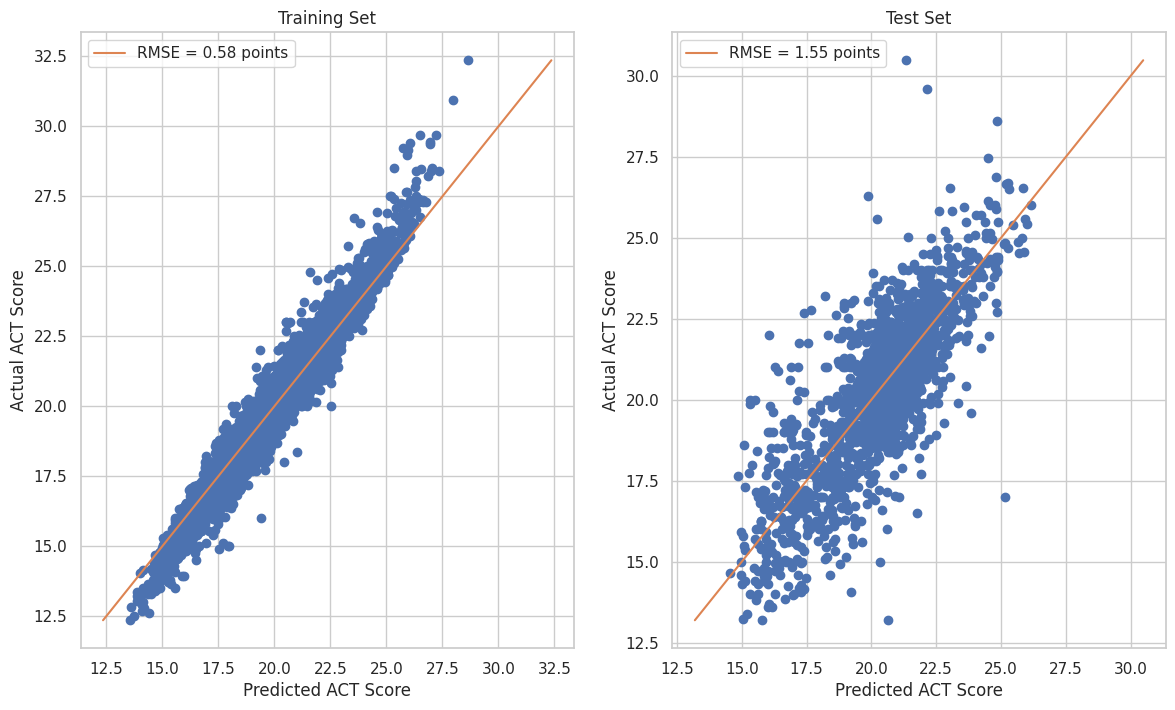

In [149]:
# Set the Y test and train to our average ACT for the respective 'test' and 'train' datasets.
y_train = train_set['average_act']
y_test = test_set['average_act']

# Select the quantitative variables that we'll have the model use to train and predict average ACT with.
features = ['rate_unemployment', 'percent_college', 'median_income', 'percent_lunch']
X_train = train_set[features]
X_test = test_set[features]

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

y_prediction_test = rf_regressor.predict(X_test)
y_prediction_train = rf_regressor.predict(X_train)

# Plot the results.
plot_results(y_train, y_test, y_prediction_train, y_prediction_test)

#Analysis
The model loses some predictive capabilities during the testing. We cannot confidently say that the model can accurately predict average ACT score when exposed to new and unseen socioeconomic data.

The RMSE is substantially lower in the training set than the test set, indicating that the model was overtuned to the training set. We could improve accuracy of our model using a bigger testing dataset, a more fundamental model, and/or tuning the parameters to better represent our overall data.

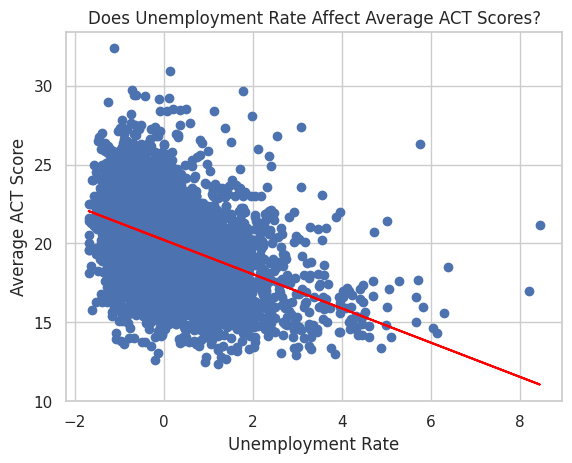

In [150]:
# Examine the relationship between unemployment rate and average ACT.
x = train_set['rate_unemployment']
y = train_set['average_act']

slope, intercept = np.polyfit(x, y, 1)

plt.scatter(x, y)

# Plot the linear regression line on the plot to give an idea of relationship direction and magnitude.
plt.plot(x, slope*np.array(x) + intercept, color='red', label='Regression Line')

plt.xlabel('Unemployment Rate')
plt.ylabel('Average ACT Score')
plt.title('Does Unemployment Rate Affect Average ACT Scores?')

plt.show()

#Analysis
We can see that as unemployment rate increases; the lower the average ACT score is.

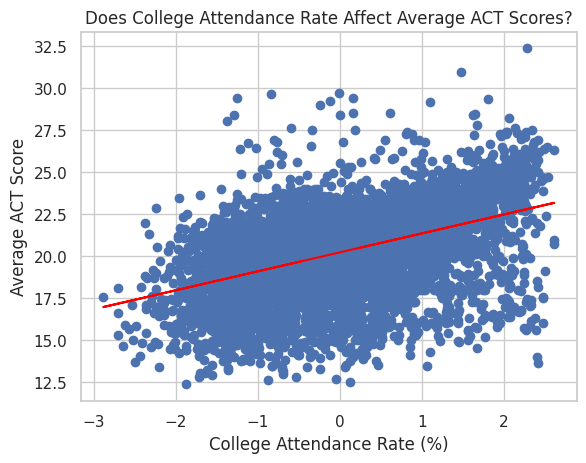

In [151]:
# Plot the relationship between college attendance rate and average ACT.
x1 = train_set['percent_college']
y1 = train_set['average_act']

slope, intercept = np.polyfit(x1, y1, 1)

plt.scatter(x1, y1)

# Plot the regression line over the plot to determine direction and magnitude.
plt.plot(x1, slope*np.array(x1) + intercept, color='red', label='Regression Line')

plt.xlabel('College Attendance Rate (%)')
plt.ylabel('Average ACT Score')
plt.title('Does College Attendance Rate Affect Average ACT Scores?')

plt.show()

#Analysis
We can see that as college attendance rate (%) increases; the average ACT score increases. Or conversely, as ACT scores increase; the rate they go to college.

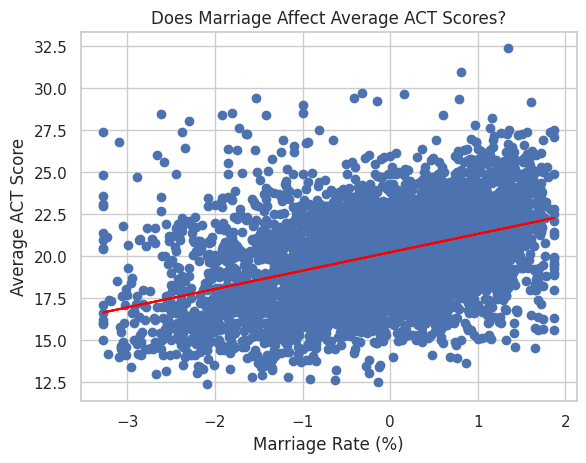

In [152]:
# Plot the relationship between marriage percentage and average ACT.
x2 = train_set['percent_married']
y2 = train_set['average_act']

slope, intercept = np.polyfit(x2, y2, 1)

plt.scatter(x2, y2)

# Once more, plot the linear regression on the plot.
plt.plot(x2, slope*np.array(x2) + intercept, color='red', label='Regression Line')

plt.xlabel('Marriage Rate (%)')
plt.ylabel('Average ACT Score')
plt.title('Does Marriage Affect Average ACT Scores?')

plt.show()

We see that as people get married more; the average ACT score increases. Conversely, as the average ACT score increases, the rate at which they get married is higher.

## Conclusion

Provide a brief description of your conclusions.

In conclusion, we can see that socioeconomic factors do play a role in the average ACT score achieved. Through the analysis of the relationship between average ACT scores and (unemployment rate, median income, marriage rate, and college attendance) that it does have an effect. Greater median income, lower unemployment rate, higher marriage rate, and higher college attendance rate all correlate to elevated average ACT scores.